In [10]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import *
warnings.filterwarnings('ignore')

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/clean_skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/clean_language.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/clean_education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [3]:
#df = pd.read_csv(config.exp_path)
#df.head()

In [4]:
#df_new['company(1th)'] = df_exp.groupby(idx)['company_id'].nth(-1).astype(str)
#df_new['company(2th)'] = df_exp.groupby(idx)['company_id'].nth(-2).astype(str)
#df_new['company(3th)'] = df_exp.groupby(idx)['company_id'].nth(-3).astype(str)

In [5]:
def load_work_experiences(path: str) -> pd.DataFrame:

    df_ = pd.read_csv(path)
    tr_cities = load_tr_cities()
    df_["start_date"] = pd.to_datetime(
        df_["start_year_month"].apply(lambda x: "-".join([str(x)[:4], str(x)[4:]]))
    )
    df_ = df_.drop(columns=["start_year_month"], axis=1)
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)

    df_ = (
        df_.loc[df_["start_date"].dt.year != 2019]
        .sort_values(by=["user_id", "start_date"])
        .reset_index(drop=True)
    )
    df_ = df_.drop_duplicates(subset=["user_id", "company_id"])
    df_["quit_date"] = df_.groupby("user_id")["start_date"].shift(-1)
    df_["days_to_quit"] = (df_["quit_date"] - df_["start_date"]).apply(
        lambda x: np.nan if str(x).split()[0] == "NaT" else int(str(x).split()[0])
    )

    emp_df = (
        df_.groupby(by="user_id", as_index=False)
        .agg(
            employee_lifetime=(
                "start_date",
                lambda x: int(str(pd.to_datetime("2019-01-01") - x.min()).split()[0]),
            ),
            employee_last_experience=(
                "start_date",
                lambda x: int(str(pd.to_datetime("2019-01-01") - x.max()).split()[0]),
            ),
            employee_total_experience=(
                "start_date",
                lambda x: int(str(x.max() - x.min()).split()[0]),
            ),
            employee_last_days_to_quit=("days_to_quit", "last"),
            employee_min_days_to_quit=("days_to_quit", "min"),
            employee_max_days_to_quit=("days_to_quit", "max"),
            employee_std_days_to_quit=("days_to_quit", "std"),
            employee_med_days_to_quit=("days_to_quit", "median"),
            employee_last_experience_month=("start_date", lambda x: x.max().month),
            employee_last_experience_year=("start_date", lambda x: x.max().year),
            #employee_first_experience_month=("start_date", lambda x: x.min().month),
            employee_first_experience_year=("start_date", lambda x: x.min().year),
            employee_nunique_company=("company_id", "nunique"),
            #employee_nunique_location = ('location', 'nunique'),
            #employee_last_location=('location', 'last'),
            company_id=("company_id", "last"),
        )
        .assign(
            employee_avg_days_to_quit=lambda x: x.employee_lifetime
            / x.employee_nunique_company,
            employee_last_experience_month_sin=lambda x: np.sin(
                2 * np.pi * x.employee_last_experience_month / 12
            ),
            employee_last_experience_month_cos=lambda x: np.cos(
                2 * np.pi * x.employee_last_experience_month / 12
            ),
        )
    )

    emp_df = emp_df.merge(df_[['user_id']].drop_duplicates().merge(
                    df_.loc[df_['start_date'].dt.year == 2018].groupby(by = 'user_id', as_index=False).agg(company_count_2018 = ('company_id', 'count'))
                    , on = ['user_id'], how = 'left'
                    ).fillna({'company_count_2018': 0}), on = ['user_id'], how = 'left')
#
    emp_df = emp_df.merge(df_[['user_id']].drop_duplicates().merge(
                    df_.loc[df_['start_date'].dt.year == 2017].groupby(by = 'user_id', as_index=False).agg(company_count_2017 = ('company_id', 'count'))
                    , on = ['user_id'], how = 'left'
                    ).fillna({'company_count_2017': 0}), on = ['user_id'], how = 'left')

    comp_df = df_.groupby(by="company_id", as_index=False).agg(
        company_avg_days_to_quit=("days_to_quit", "mean"),
        company_std_days_to_quit=("days_to_quit", "std"),
        company_max_days_to_quit=("days_to_quit", "max"),
        #company_min_days_to_quit=("days_to_quit", "min"),
        company_med_days_to_quit=("days_to_quit", "median"),
        company_skew_days_to_quit=("days_to_quit", "skew"),
        company_nunique_employees=("user_id", "nunique"),
        #company_nunique_location = ('location', 'nunique'),
        company_lifetime=(
           "start_date",
           lambda x: int(str(pd.to_datetime("2019-01-01") - x.min()).split()[0]),
        ),
        company_last_hire=(
           "start_date",
           lambda x: int(str(pd.to_datetime("2019-01-01") - x.max()).split()[0]),
        ),
    )

    return emp_df.merge(comp_df, on=["company_id"], how="left").assign(
        avg_days_to_quit_diff=lambda x: x.company_avg_days_to_quit
        - x.employee_avg_days_to_quit,
        avg_days_to_quit_ratio=lambda x: x.company_avg_days_to_quit
        / x.employee_avg_days_to_quit,
        company_hire_ratio = lambda x: x.company_lifetime / x.company_nunique_employees
    )


In [6]:
#df = load_work_experiences('../../../datasets/garanti-bbva-data-camp/work_experiences.csv')

#df.head(8)

,user_id,employee_lifetime,employee_last_experience,employee_total_experience,employee_last_days_to_quit,employee_min_days_to_quit,employee_max_days_to_quit,employee_std_days_to_quit,employee_med_days_to_quit,employee_last_experience_month,...,company_std_days_to_quit,company_max_days_to_quit,company_med_days_to_quit,company_skew_days_to_quit,company_nunique_employees,company_lifetime,company_last_hire,avg_days_to_quit_diff,avg_days_to_quit_ratio,company_hire_ratio
0,0,4870,4870,0,NaN,NaN,NaN,NaN,NaN,9,...,NaN,NaN,NaN,NaN,5,4870,2071,NaN,NaN,974.000000
1,2,761,214,547,365.0,182.0,365.0,129.400541,273.5,6,...,559.321464,1065.0,669.5,NaN,4,1249,214,415.833333,2.639290,312.250000
2,5,579,579,0,NaN,NaN,NaN,NaN,NaN,6,...,NaN,365.0,365.0,NaN,3,579,549,-214.000000,0.630397,193.000000
3,7,914,31,883,883.0,883.0,883.0,NaN,883.0,12,...,NaN,NaN,NaN,NaN,6,31,31,NaN,NaN,5.166667
4,10,1979,245,1734,1734.0,1734.0,1734.0,NaN,1734.0,5,...,808.719538,5206.0,701.0,1.817045,1410,11902,31,-77.219463,0.921961,8.441135
5,11,518,153,365,365.0,365.0,365.0,NaN,365.0,8,...,NaN,NaN,NaN,NaN,2,153,153,NaN,NaN,76.500000
6,12,2010,61,1949,1096.0,31.0,1096.0,553.019288,822.0,11,...,114.654881,426.0,212.0,0.129315,36,1005,61,-305.222222,0.392593,27.916667
7,13,2863,306,2557,2557.0,2557.0,2557.0,NaN,2557.0,3,...,NaN,NaN,NaN,NaN,2,306,306,NaN,NaN,153.000000


In [37]:
#df['employee_last_days_to_quit'].isnull().sum()

15977

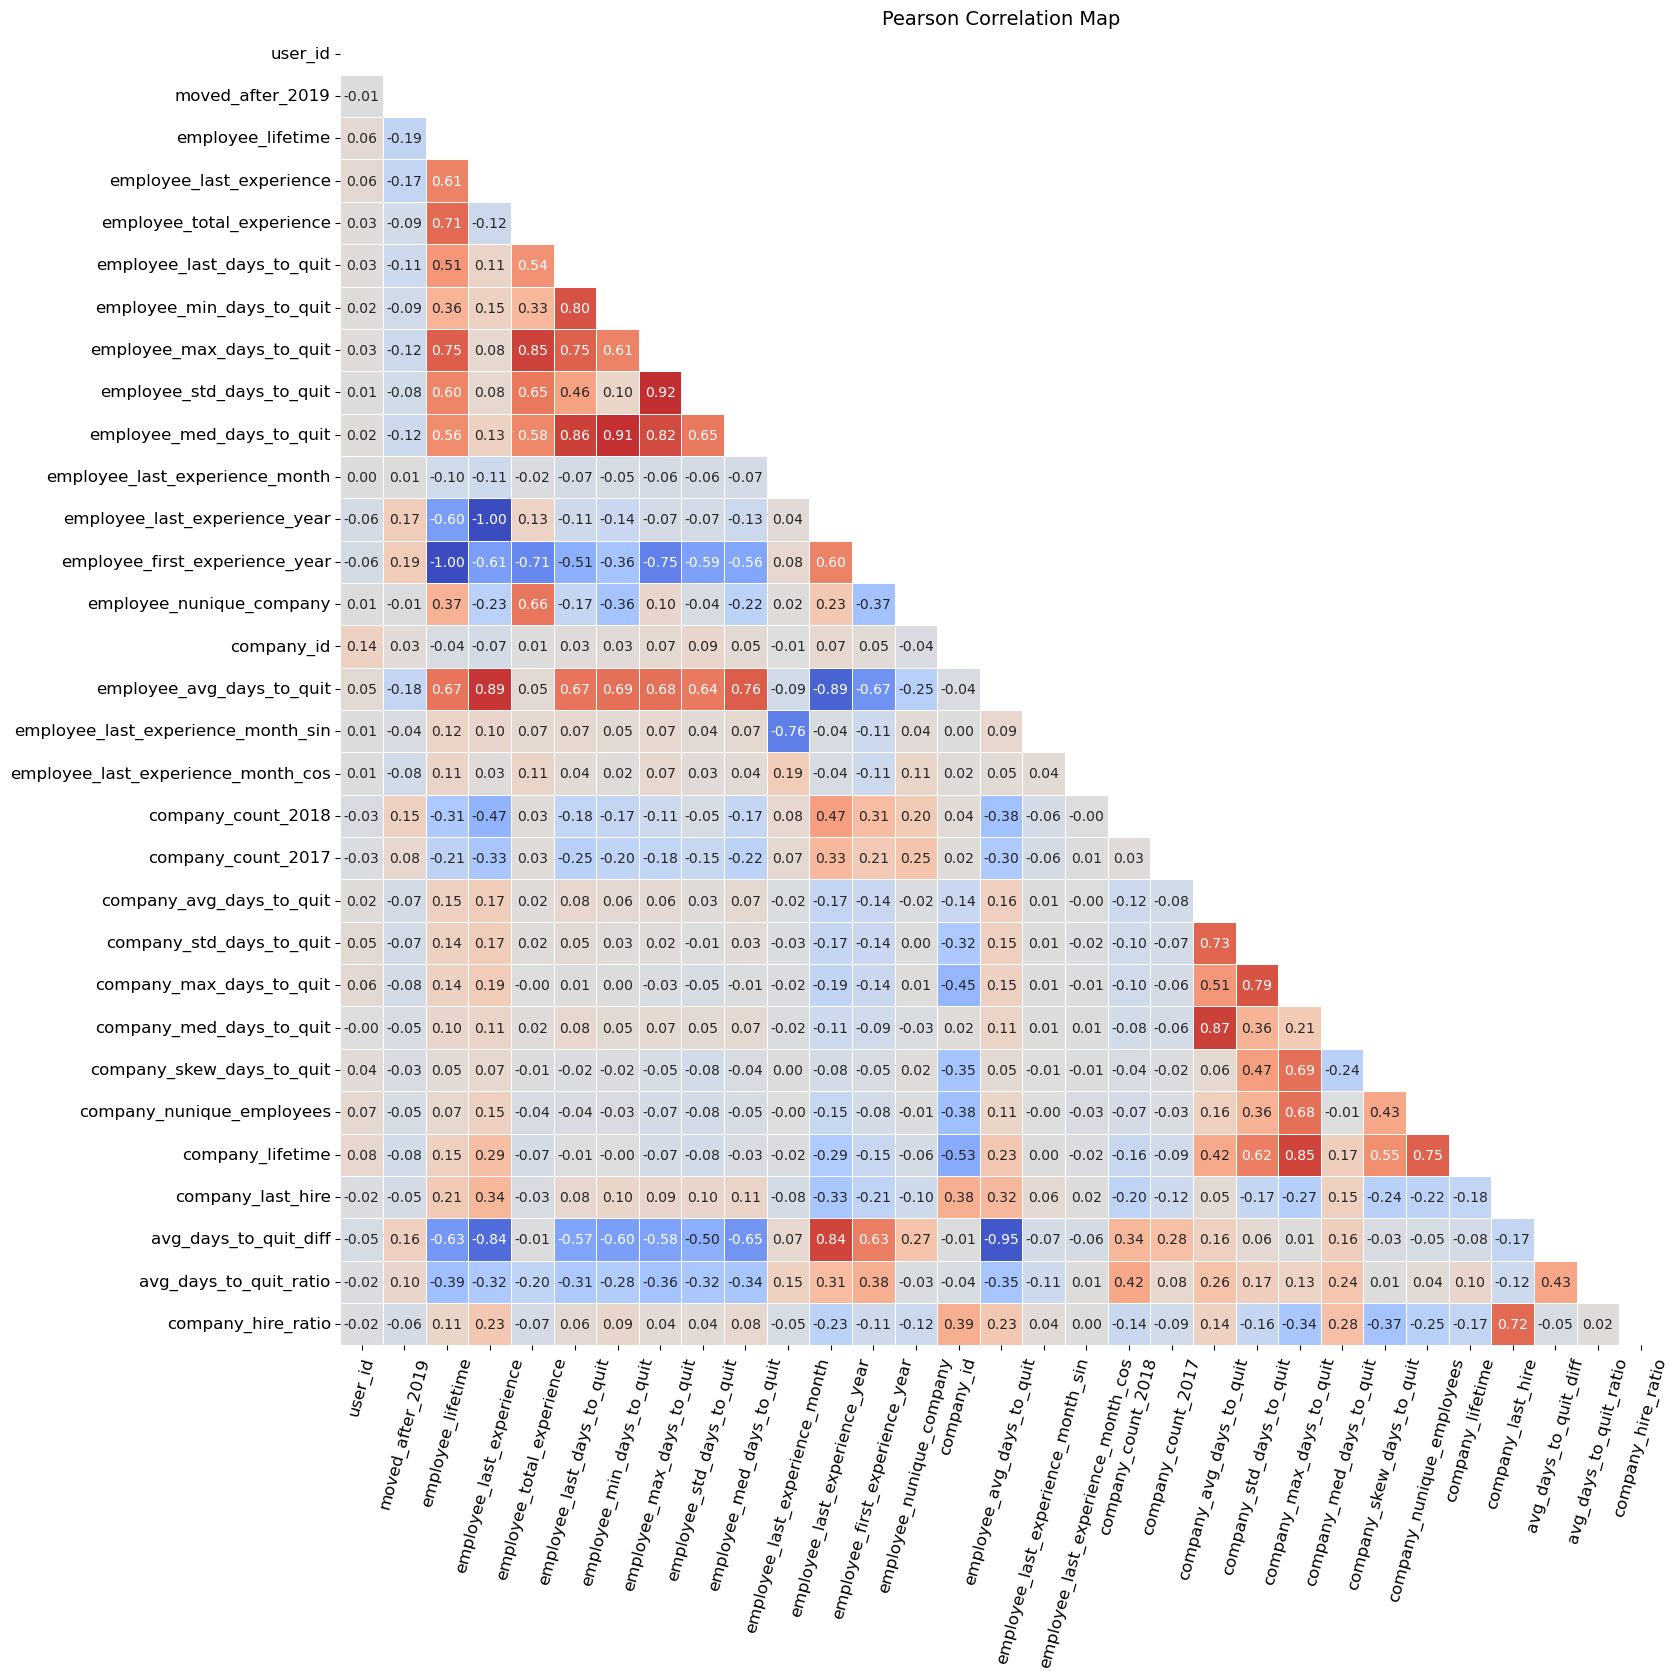

In [7]:
#train = pd.read_csv(config.train_path)

#corr_map(train.merge(df, on = ['user_id'], how = 'left'))

In [41]:
#comp_df = df.drop_duplicates(subset = ['user_id', 'company_id'])
#
#comp_df['quit_date'] = comp_df.groupby('user_id')['start_date'].shift(-1)
#
#comp_df['days_to_quit'] = (comp_df['quit_date'] - comp_df['start_date']).apply(lambda x: np.nan if str(x).split()[0] == 'NaT' else int(str(x).split()[0]))
#
#comp_df

In [42]:
#train_df = pd.read_csv(config.train_path)
#test_df = pd.read_csv(config.test_path)
#sub = pd.read_csv(config.sub_path)
#
#print(f'train_df shape: {train_df.shape}')
#print(f'test_df shape: {test_df.shape}')
#df = train_df.append(test_df).reset_index(drop = True)
#df.loc[df['industry'] == '-1', 'industry'] = np.nan
#df.head()

In [46]:
#train = pd.read_csv(config.train_path)
#
#corr_map(train.merge(df, on = ['user_id'], how = 'left'))

In [ ]:
#corr_map(df)

In [ ]:
#emp_df = df.groupby(by = "user_id", as_index=False).agg(
#        employee_lifetime=(
#            "start_date",
#            lambda x: int(str(pd.to_datetime("2019-01-01") - x.min()).split()[0]),
#        ),
#        employee_last_experience=(
#            "start_date",
#            lambda x: int(str(pd.to_datetime("2019-01-01") - x.max()).split()[0]),
#        ),
#        employee_total_experience=(
#            "start_date",
#            lambda x: int(str(x.max() - x.min()).split()[0]),
#        ),
#        employee_last_experience_month=("start_date", lambda x: x.max().month),
#        employee_last_experience_year=("start_date", lambda x: x.max().year),
#        employee_last_company_id = ('company_id', 'last'),
#        employee_nunique_company = ('company_id', 'nunique'),
#    ).assign(
#        employee_avg_days_to_quit = lambda x: x.employee_lifetime / x.employee_nunique_company
#    )
#
#emp_df
#

In [ ]:
#emp_df.groupby('user_id')['days_to_quit'].shift(1).isnull().sum()

In [ ]:
#df.groupby(by = 'company_id', as_index=False).agg(company_avg_days_to_quit = ('days_to_quit', 'mean'))

In [ ]:
#df.groupby('user_id').agg(total_experience = ('start_date', lambda x: int(str(pd.to_datetime('2019-01-01') - x.min()).split()[0]))).merge(
#
#    df.groupby('user_id').agg(unique_company = ('company_id', 'nunique')), on = ['user_id'], how = 'left'
#
#).reset_index().assign(avg_days_to_quit = lambda x: x.total_experience / x.unique_company)

In [ ]:
#df.loc[df['location'].astype(str).str.contains('tekno'), 'location'].value_counts()[:20]

In [ ]:
#df.loc[(df['location'].astype(str).str.contains('Kemalpaşa')) & (~df['location'].astype(str).str.contains('aa')), 'location'].value_counts().keys().tolist()

In [ ]:
def load_work_experiences_v2(path: str) -> pd.DataFrame:

    df_ = pd.read_csv(path)
    df_["start_date"] = pd.to_datetime(
        df_["start_year_month"].apply(lambda x: "-".join([str(x)[:4], str(x)[4:]]))
    )
    df_ = df_.drop(columns=["start_year_month"], axis=1)

    df_ = (
        df_.loc[df_["start_date"].dt.year != 2019]
        .sort_values(by=["user_id", "start_date"])
        .reset_index(drop=True)
    )
    df_ = df_.drop_duplicates(subset=["user_id", "company_id"])
    df_["quit_date"] = df_.groupby("user_id")["start_date"].shift(-1)
    df_["days_to_quit"] = (df_["quit_date"] - df_["start_date"]).apply(
        lambda x: np.nan if str(x).split()[0] == "NaT" else int(str(x).split()[0])
    )

    emp_df = (
        df_.groupby(by="user_id", as_index=False)
        .agg(
            employee_lifetime=(
                "start_date",
                lambda x: int(str(pd.to_datetime("2019-01-01") - x.min()).split()[0]),
            ),
            employee_last_experience=(
                "start_date",
                lambda x: int(str(pd.to_datetime("2019-01-01") - x.max()).split()[0]),
            ),
            employee_total_experience=(
                "start_date",
                lambda x: int(str(x.max() - x.min()).split()[0]),
            ),
            employee_last_days_quit=("days_to_quit", "last"),
            employee_min_days_quit=("days_to_quit", "min"),
            employee_max_days_quit=("days_to_quit", "max"),
            employee_std_days_quit=("days_to_quit", "std"),
            employee_med_days_quit=("days_to_quit", "median"),
            employee_last_experience_month=("start_date", lambda x: x.max().month),
            employee_last_experience_year=("start_date", lambda x: x.max().year),
            employee_nunique_company=("company_id", "nunique"),
            company_id=("company_id", "last"),
        )
        .assign(
            employee_avg_days_to_quit=lambda x: x.employee_lifetime
            / x.employee_nunique_company,
            employee_last_experience_month_sin=lambda x: np.sin(
                2 * np.pi * x.employee_last_experience_month / 12
            ),
            employee_last_experience_month_cos=lambda x: np.cos(
                2 * np.pi * x.employee_last_experience_month / 12
            ),
        )
    )

    comp_df = df_.groupby(by="company_id", as_index=False).agg(
        company_avg_days_to_quit=("days_to_quit", "mean"),
        company_std_days_to_quit=("days_to_quit", "std"),
        company_max_days_to_quit=("days_to_quit", "max"),
        company_med_days_to_quit=("days_to_quit", "median"),
        company_skew_days_to_quit=("days_to_quit", "skew"),
        company_nunique_employees=("user_id", "nunique"),
    )

    return emp_df.merge(comp_df, on=["company_id"], how="left").assign(
        avg_days_to_quit_diff=lambda x: x.company_avg_days_to_quit
        - x.employee_avg_days_to_quit,
        avg_days_to_quit_ratio=lambda x: x.company_avg_days_to_quit
        / x.employee_avg_days_to_quit,
    )